<a href="https://colab.research.google.com/github/Aditya3392/Classification-of-Galaxy-Type/blob/main/spiral4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

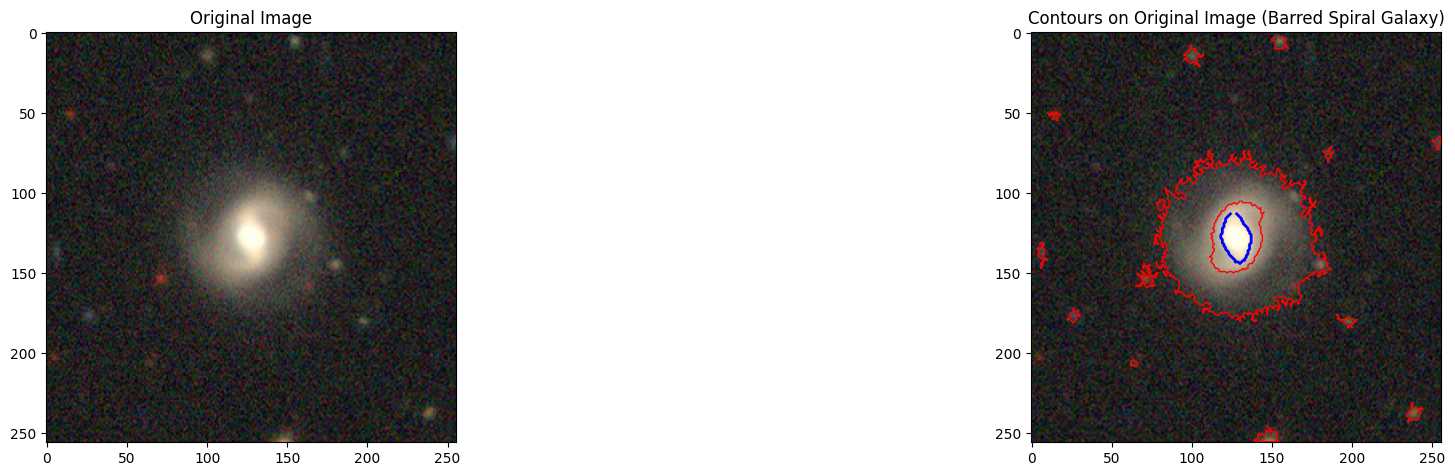

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path):
    # Load the image using OpenCV
    img = cv2.imread(image_path)
    return img

def calculate_ellipticity(ellipse):
    # Calculate ellipticity as the ratio of the semi-minor axis to the semi-major axis
    semi_major_axis = ellipse[1][0]
    semi_minor_axis = ellipse[1][1]

    if semi_major_axis > semi_minor_axis:
        ellipticity = 1 - semi_minor_axis / semi_major_axis
    else:
        ellipticity = 1 - semi_major_axis / semi_minor_axis

    return ellipticity

# Load the image
image_path = '/content/image_8008.png'  # Replace with the actual image path
img_array = [load_image(image_path)]

# Additional image processing: Convert to grayscale
gray = cv2.cvtColor(img_array[0], cv2.COLOR_BGR2GRAY)

# Apply thresholding to emphasize the brightest regions
_, thresholded_img = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

# Find contours in the thresholded image
contours, _ = cv2.findContours(thresholded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the contour with the largest area (bulge)
if contours:
    max_contour = max(contours, key=cv2.contourArea)

    # Fit an ellipse to the largest contour (bulge)
    ellipse = cv2.fitEllipse(max_contour)

    # Plot the images with the detected ellipse
    plt.figure(figsize=(18, 6))

    # Plot the original image
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(img_array[0], cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    # # Plot the thresholded image with the detected ellipse in blue color
    # plt.subplot(132)
    #  plt.imshow(thresholded_img, cmap='gray')
    # cv2.ellipse(thresholded_img, ellipse, (0, 0, 255), 2)

    # Plot the contour on the original image
    plt.subplot(133)
    plt.imshow(cv2.cvtColor(img_array[0], cv2.COLOR_BGR2RGB))
    plt.plot(max_contour[:, 0, 0], max_contour[:, 0, 1], color='b', linewidth=2)

    # Identify lower brightness parts (arms) connected to the bulge
    lower_brightness_threshold = 150  # Adjust as needed
    _, arms_mask = cv2.threshold(gray, lower_brightness_threshold, 255, cv2.THRESH_BINARY)

    # Combine the arms mask with the thresholded image
    arms_mask = cv2.bitwise_and(arms_mask, cv2.bitwise_not(thresholded_img))

    # Find contours in the arms mask
    contours_arms, _ = cv2.findContours(arms_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Plot additional contours (arms)
    for contour in contours_arms:
        # Filter out small contours (adjust the area threshold as needed)
        if cv2.contourArea(contour) > 50:
            plt.plot(contour[:, 0, 0], contour[:, 0, 1], color='r', linewidth=1)

    # Identify third level of lower brightness parts (spiral arms)
    third_brightness_threshold = 50  # Adjust as needed
    _, third_level_mask = cv2.threshold(gray, third_brightness_threshold, 255, cv2.THRESH_BINARY)

    # Combine the third level mask with the arms mask
    third_level_mask = cv2.bitwise_and(third_level_mask, cv2.bitwise_not(arms_mask))

    # Find contours in the third level mask
    contours_third_level, _ = cv2.findContours(third_level_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Plot additional contours (third level) with the same color as the arms
    for contour in contours_third_level:
        # Filter out small contours (adjust the area threshold as needed)
        if cv2.contourArea(contour) > 10:
            plt.plot(contour[:, 0, 0], contour[:, 0, 1], color='r', linewidth=1)

    # Calculate ellipticity for the bulge
    bulge_ellipticity = calculate_ellipticity(ellipse)

    # Calculate ellipticity for the third level contours (arms)
    if len(contours_third_level) > 0 and len(contours_third_level[0]) >= 5:
        third_ellipse = cv2.fitEllipse(contours_third_level[0])  # Assuming there is only one significant third level contour
        third_ellipticity = calculate_ellipticity(third_ellipse)
    else:
        third_ellipticity = 0  # Set a default value if there are not enough points

    # Calculate the difference in ellipticity
    ellipticity_difference = np.abs(bulge_ellipticity - third_ellipticity)

    # Set a threshold for the difference in ellipticity
    ellipticity_threshold = 0.4  # Adjust as needed

    # Check if the difference in ellipticity exceeds the threshold
    if ellipticity_difference > ellipticity_threshold:
        galaxy_type = "Barred Spiral Galaxy"
    else:
        # Calculate ellipticity for the second level contours (arms)
        if len(contours_arms) > 0 and len(contours_arms[0]) >= 5:
            arms_ellipse = cv2.fitEllipse(contours_arms[0])  # Assuming there is only one significant arm contour
            arms_ellipticity = calculate_ellipticity(arms_ellipse)
        else:
            arms_ellipticity = 0  # Set a default value if there are not enough points

        # Set a threshold for the ellipticity of the second level contours
        second_level_ellipticity_threshold = 0.4  # Adjust as needed

        # Check if the ellipticity of the second level contours exceeds the threshold
        if arms_ellipticity > second_level_ellipticity_threshold:
            galaxy_type = "Barred Spiral Galaxy"
        else:
            galaxy_type = "Normal Spiral Galaxy"

    plt.title(f'Contours on Original Image ({galaxy_type})')

    plt.show()
else:
    print("No contours found.")
